In [38]:
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, plot_confusion_matrix

In [23]:
#Functions
def clean_comments(comment):
    #first remove apostrphes commas signs...
    no_space_replacement = re.compile(r'[\.\'<>,\"\)%(’‘–-]')
    space_replacement = re.compile(r'/')
    #Then emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    clean_comment = no_space_replacement.sub('', comment)
    clean_comment = space_replacement.sub(' ', clean_comment)
    clean_comment = emoji_pattern.sub(r'', clean_comment)
    
    stop_words = stopwords.words('english')
    by_words = clean_comment.split(' ')
    
    more_clean = [word for word in by_words if word not in stop_words]
    more_clean = ' '.join(more_clean)
    
    return more_clean.lower()
    
#Have the labeled output in the last column
def reorganize_columns(df):
    original_col_list = list(df.columns)
    new_col_list = original_col_list[::-1]
    reorganized_df = df[new_col_list]
    return reorganized_df

#Deal with annotations... take the most common opinion.
def compact_annotations(annotation_list):
    most_common_annotations = list()
    
    for annotation in annotation_list:
        string = str(annotation)
        opinions = string.split('/')
        most_common_opinion = Counter(opinions).most_common(1)[0][0]
        most_common_annotations.append(most_common_opinion)
    
    return most_common_annotations

#Measure opinion agreement
def consensus(annot_list):
    agreement_rates = list()
    for annot in annot_list:
        opinion_count = Counter(annot).most_common(1)[0][1]
        rate = opinion_count/len(annot)

        #If theres 3 opinions, which one is the most common, divide
        #by the total (3) opinions and get the rate of the most common one
        #and if rate is 0.5, remove those rows
        
        if rate > 0.5:
        
            if Counter(annot).most_common(1)[0][0] == '1':
                agreement_rates.append(('pro-brexit', rate))
            elif Counter(annot).most_common(1)[0][0] == '0':
                agreement_rates.append(('anti-brexit', rate))
            else:
                agreement_rates.append(('non-cat', rate))
        
        else:
            
            agreement_rates.append(('contradicting', rate))
            
    return agreement_rates

#Remove comments (rows) with contradicting opinion
def remove_conflicts(data_frame):
    for row in data_frame.iterrows():
        annot = row[1]['Annotations'].split('/') 
        ctr = Counter(annot)
        #If mostly '-1'      DELETE
        #If same '0' and '1' DELETE
        #If 1/-1   or   0/-1 DELETE
        if len(ctr) != 1:
            if (ctr['0'] == ctr['1']) or (ctr.most_common(1)[0][0] == '-1') or (ctr['0'] == ctr['-1']) or (ctr['1'] == ctr['-1']):
                # useless row
                data_frame.drop(index=row[0], inplace=True)
        
    return data_frame

In [24]:
#Read data
df = pd.read_csv('a2a_train_final.tsv', sep='\t', names = ["Annotations", "Comment"])

In [25]:
#Re-organize data
df = reorganize_columns(df)

In [26]:
#Measure consensus
consensus_rate = consensus([str(annotation).split('/') for annotation in df['Annotations']])


Text(0.5, 1.0, 'Number of labeled categories')

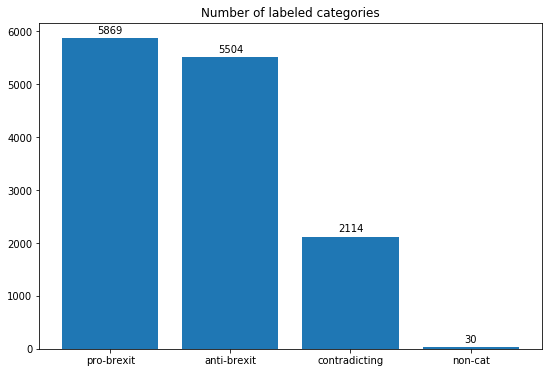

In [27]:
x = [rate[0] for rate in consensus_rate]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
bars = ax.bar(Counter(x).keys(), Counter(x).values())
for rect in bars:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.title("Number of labeled categories")

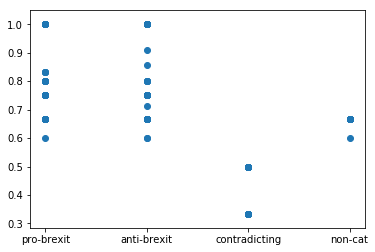

In [8]:
consensus_rate = consensus([str(annotation).split('/') for annotation in df['Annotations']])
x_scatter = [rate[0] for rate in consensus_rate]
y_scatter = [rate[1] for rate in consensus_rate]

plt.scatter(x_scatter, y_scatter)

In [28]:
#Remove contradicting opinions
df = remove_conflicts(df)
print("done")

done


Text(0.5, 1.0, 'Number of labeled categories')

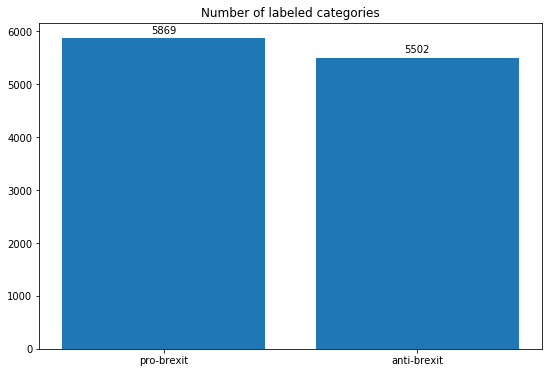

In [29]:
consensus_rate = consensus([str(annotation).split('/') for annotation in df['Annotations']])
x = [rate[0] for rate in consensus_rate]

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
bars = ax.bar(Counter(x).keys(), Counter(x).values())
for rect in bars:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.title("Number of labeled categories")
# this graph means that we can use accuracy as metric

In [32]:
#Take the most common opinion 
annotations_compacted = compact_annotations(df['Annotations'])
df['Annotations'] = annotations_compacted

In [33]:
#Clean the comments
df['Comment'] = df['Comment'].apply(clean_comments)

In [34]:
xtrain = df["Comment"]
ytrain = df["Annotations"]

In [35]:
#Read test data and re-organize
test_df = pd.read_csv('a2a_test_final.tsv', sep='\t', names=['Annotations', 'Comment'])
test_df = reorganize_columns(test_df)
test_df['Comment'] = test_df['Comment'].apply(clean_comments)

In [36]:
xtest = test_df['Comment']

In [37]:
ytest = test_df['Annotations'].apply(str)

In [40]:
ct_vec = CountVectorizer(ngram_range=(1,2))
xtrain_counts = ct_vec.fit_transform(xtrain)
xtrain_counts = preprocessing.scale(xtrain_counts, with_mean=False)
xtest_transformed = ct_vec.transform(xtest)

In [18]:
classifiers = [MultinomialNB(), SVC(), RidgeClassifier(),  MLPClassifier()]
scores = list()
names = ['MultinomialNB', 'SVC', 'Ridge classifier', 'Random forest classifier']
for i, clf in enumerate(classifiers):
    # clf_scores = list()
    scores.append((names[i], mean(cross_val_score(clf, xtrain_counts, ytrain, cv=5))))

print("Scores:")
for i in scores:
    print(i)

print("Best classifier: ", max(scores, key=lambda tup: tup[1]))

In [19]:
#try classifiers and parameters
names = ['MultinomialNB', 'LinearSVC', 'Logistic Regression' 'RandomForestClassifier']
classifiers = [MultinomialNB(), LinearSVC(), LogisticRegression(), RandomForestClassifier()]
param_grid = [
            [{'alpha':[i/10 for i in range(6,30)]}],
            [{'C':[1.5, 1.0], 'loss':['hinge','squared_hinge']}],  
            [{'C':[0.8, 1.0, 1.2]}],
            [{'n_estimators':[i for i in range(100,200,50)], 'max_depth':[j for j in range(3,15)]}],
            ]


results_cv_list = list()
best_something = list()
scores_list = list()
for name, classifier, parameters in zip(names, classifiers, param_grid):
    print("Running {} ...".format(name))
    grid = GridSearchCV(classifier, param_grid = parameters, n_jobs = 3, cv = 5, scoring='accuracy')
    cpx = grid.fit(xtrain_counts, ytrain)
    score =  cpx.score(xtest_transformed, ytest)
    scores_list.append("{} score: {}".format(name, score))
    print("{} score: {}".format(name, score))
    best_something.append((name, cpx.best_estimator_, cpx.best_params_, cpx.best_score_))
    print(name,  cpx.best_estimator_, cpx.best_params_, cpx.best_score_)
    results_cv_list.append((name, cpx.cv_results_))

Running MultinomialNB ...
MultinomialNB score: 0.7896551724137931
MultinomialNB MultinomialNB(alpha=1.9, class_prior=None, fit_prior=True) {'alpha': 1.9} 0.7135683454628046
Running LinearSVC ...


C:\Program Files\Python37\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC score: 0.5310344827586206
LinearSVC LinearSVC(C=0.8, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0) {'C': 0.8, 'loss': 'squared_hinge'} 0.6050465559067143
Running RandomForestClassifier ...
RandomForestClassifier score: 0.5310344827586206
RandomForestClassifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=14, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False) {'max_depth': 14,

In [20]:
grid = GridSearchCV(MultinomialNB(), param_grid = {'alpha':[i/10 for i in range(4,30)]}, n_jobs = -1, cv = 5, scoring='accuracy')
grid.fit(xtrain_counts, ytrain)
print('MultinomialNB, with params: ', grid.best_params_, 'with score: ', grid.best_score_)


grid.fit(xtrain_counts, ytrain)
yguess = grid.predict(xtest_transformed)

MultinomialNB, with params:  {'alpha': 2.8} with score:  0.7150633921926798


Using multinomial naive bayes classifier:
Accuracy score:  0.7913793103448276
TRUE POSITIVES: 511 
TRUE NEGATIVES: 407 
FALSE POSITIVES: 105 
FALSE NEGATIVES: 137
Precision:  0.8295454545454546
Recall:  0.7885802469135802
f-beta 0.5 =  1.2359979191954222


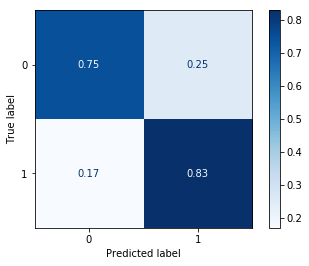

In [21]:
print("Using multinomial naive bayes classifier:")
print("Accuracy score: ", accuracy_score(yguess, ytest))

disp = plot_confusion_matrix(grid, xtest_transformed, ytest,
                                 cmap=plt.cm.Blues, normalize='true')

tn, fp, fn, tp = confusion_matrix(yguess, ytest).ravel()

print("TRUE POSITIVES: {} \nTRUE NEGATIVES: {} \nFALSE POSITIVES: {} \nFALSE NEGATIVES: {}".format(tp,tn,fp,fn))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print("Precision: ", precision)
print("Recall: ", recall)

fbeta = 1/( 0.5*(precision) + ((1-0.5)*recall) )
print('f-beta 0.5 = ', fbeta)